In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
from c3.utils.tf_utils import tf_abs_squared
import matplotlib as mpl
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

2022-05-19 13:52:22.158482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 13:52:22.158532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [3]:
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.1e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]

In [4]:
# labels for all states
level_labels = []
level_labels_with_leakage = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels.append(None)
        else:
            level_labels.append(f"{i},{j}")
        level_labels_with_leakage.append(f"{i},{j}")

for i,l in enumerate(level_labels):
    print(i, l, level_labels_with_leakage[i])

0 0,0 0,0
1 0,1 0,1
2 0,2 0,2
3 0,3 0,3
4 1,0 1,0
5 1,1 1,1
6 1,2 1,2
7 1,3 1,3
8 2,0 2,0
9 2,1 2,1
10 2,2 2,2
11 2,3 2,3
12 3,0 3,0
13 3,1 3,1
14 3,2 3,2
15 3,3 3,3


In [5]:
def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name, "svg"), colourMap='hsv')

In [6]:
output = DataOutput("test_output")


def getInfidelity(i, j, qubitFrequency: float, anharmonicity: float, couplingStrength: float) -> np.array:
    # Initialise the qubits and drive lines
    qubits = createQubits(
        qubit_levels_list=qubit_levels,
        freq_list=[qubit_frequencies[0], qubitFrequency],
        anharm_list=[anharmonicities[0], anharmonicity],
        t1_list=t1s,
        t2star_list=t2stars,
        qubit_temp=qubit_temps
    )
    coupling = createChainCouplings([couplingStrength], qubits)
    drives = createDrives(qubits)

    # Create the model
    model = Mdl(qubits, coupling + drives)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)

    # create the generator
    generator = createGenerator(drives, useDrag=False, usePWC=False)
    envelopes = []
    carriers = []
    t_final = 200e-9
    for idx in [0, 1]:
        env = createNoDriveEnvelope(t_final)
        env.name = f"envelope_{drives[idx].name}"
        envelopes.append(env)

        carrier_parameters = {
            "freq": Qty(value=5e9, min_val=0.98 * 5e9, max_val=1.02 * 5e9, unit="Hz 2pi"),
            "framechange": Qty(value=0.01, min_val=-np.pi, max_val=3 * np.pi, unit="rad")
        }
        carrier = pulse.Carrier(
            name=f"carrier_{drives[idx].name}",
            desc="Frequency of the local oscillator",
            params=carrier_parameters,
        )
        carriers.append(carrier)

    # create the instruction
    ideal_gate = np.eye(model.tot_dim)
    gate = gates.Instruction(
        name="unity",
        targets=[0, 1],
        t_start=0.0,
        t_end=t_final,
        channels=[d.name for d in drives],
        ideal=ideal_gate,
    )
    for i in range(len(drives)):
        gate.add_component(envelopes[i], drives[i].name)
        gate.add_component(carriers[i], drives[i].name)

    # calculate the propagator
    parameter_map = PMap(instructions=[gate], model=model, generator=generator)
    exp = Exp(pmap=parameter_map)
    exp.set_opt_gates([gate.get_key()])
    exp.compute_propagators()
    U = exp.propagators[gate.get_key()]
    printMatrix(U, level_labels, f"propagator{i}-{j}_f{qubitFrequency}_a{anharmonicity}_c{couplingStrength}", output)
    fidelity = tf_abs_squared(
        np.trace(U.numpy()) / np.prod(qubit_levels)
    )
    return 1.0 - fidelity

In [7]:
couplings = np.arange(5e6, 50e6, 2e6)
frequencies = np.arange(4.0e9, 4.9e9, 0.02e9)
anharmonicities = np.arange(-600e6, -50e6, 50e6)
x = frequencies
y = anharmonicities

In [ ]:
allValues = np.zeros(shape=(len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        print(f"{i+1} / {len(x)}", f"{j+1} / {len(y)}")
        fid = getInfidelity(i, j, x[i], y[j], 30e6)
        allValues[i, j] = fid
        print(fid)

np.save('./test_output/infidelities', allValues)

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

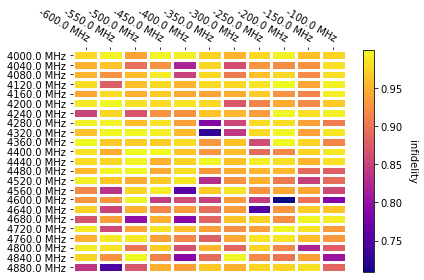

In [12]:
data = np.load('./test_output/infidelities.npy')[::2,:]

fig, ax = plt.subplots()
rowLabels = [f"{a / 1e6} MHz" for a in x[::2]]
colLabels = [f"{a / 1e6} MHz" for a in y]
im, cbar = heatmap(data, rowLabels, colLabels, ax=ax, cmap="plasma", cbarlabel="infidelity",
                   aspect='auto')
#texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
#plt.show()
plt.savefig('./test_output/infidelities.svg')